In [2]:
class Value:
    def __init__(self, data, _children = (), _operation = '' , _label = ''):
        self.data = data           # data to be stored 
        self.grad= 0.0
        self.prev = set(_children)   # store the previous datas (children) in a set
        self._operation = _operation # The operation associated with this instance. Defaults to an empty string.
        self._label = _label
    def __repr__(self):
        # used for printing the object 
        return f"data(data={self.data} label={self._label} operation={self._operation})"


    def __add__(self, other , _label =''):
        # a+b internally a.__add__(b)
        out = Value(self.data + other.data , _children = (self, other) , _operation = '+', _label =_label)
        return out    

    def __mul__(self, other, _label = ''):
        # a*b internally a.__mul__(b)
        out = Value(self.data * other.data , _children = (self, other) , _operation = '*' , _label =_label)
        return out
    
    

In [3]:
a = Value(2.0,_label="a")
b= Value(-3.0,_label='b')
c = Value(10.0,_label= 'c')
e = a*b
e._label= 'e'
d= e+c
d._label= 'd'
f=Value(-2.0 , _label='f')
L =d*f
L._label= 'L'



In [4]:
from graphviz import Digraph

def trace(root):
    """
    Traverses a tree structure starting from the given root node and builds sets of nodes and edges.

    Args:
        root: The root node of the tree to be traversed.

    Returns:
        A tuple containing two sets:
            - nodes: A set of all nodes in the tree.
            - edges: A set of tuples representing the edges between nodes in the tree.
    """
    nodes , edges = set() ,set() # to 
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node.prev:
                edges.add((child ,node))
                build(child)
    build(root)
    
    return nodes, edges

def draw_dot(root , format = 'svg', rankdir = 'LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR','TB']
    
    nodes, edges= trace(root)
    dot = Digraph(format = format, graph_attr= {'rankdir':rankdir})

    for node in nodes: 
        uid_for_node= str(id(node))
        dot.node(name = uid_for_node, label = f"{{ {node._label} | {node.data:.4f} | {node.grad:.4f} }}", shape = "record" )

        if node._operation:
            uid_for_operation = uid_for_node + node._operation
            dot.node(name= uid_for_operation, label = f"{node._operation}")
            dot.edge(uid_for_operation, uid_for_node) # connect operation to node
        
    for node1 , node2 in edges:
        dot.edge(str(id(node1)), str(id(node2))+node2._operation)
    return dot
        
    

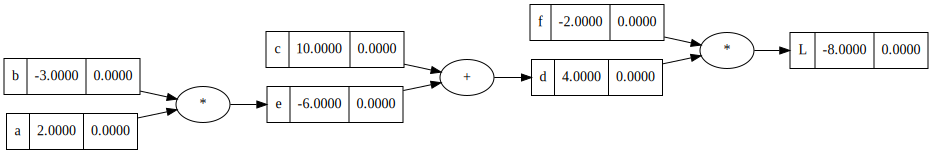

In [5]:
draw_dot(L)

## Gradient Calculation

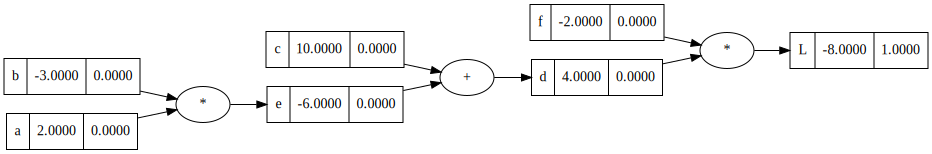

In [6]:
#dL/dL == 1
L.grad = 1.0
draw_dot(L)

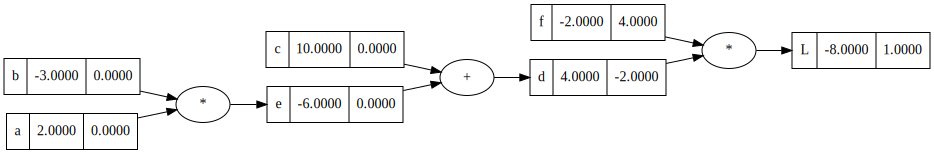

In [7]:
#dL/dd   L=d*f therefore dL/dd = e
# and dL/df = d
d.grad = f.data
f.grad = d.data
draw_dot(L)

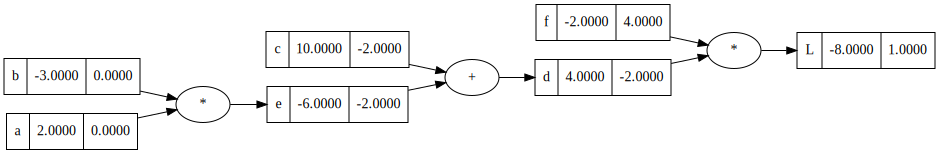

In [8]:
"""
We want :
dL/de = ?
We have :
dL/dd and dd/de -> local gradient d=e+c dd/de =1 

using CHAIN RULE :
dL/de = (dL/dd)*(dd/de)
"""
e.grad = d.grad * 1.0
# same for c
c.grad = d.grad * 1.0
draw_dot(L)